# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
## Problem Formulation

Consider the rocket landing in 2-dimensions by setting the state vector into $x(t)=[x_1(t), x_2(t), \phi(t), \dot{x}_1(t), \dot{x}_2(t), \dot{\phi}(t)]^T$ where $x_1$ and $x_2$ are positions in x and y coordinates and $\phi$ is the orientation of the rocket. The discrete time dynamics can be formulated as:

$$
\begin{aligned}
x_1(t+1) = x_1(t) + \dot{x}_1(t) \Delta t, \\
x_2(t+1) = x_2(t) + \dot{x}_2(t) \Delta t, \\
\phi(t+1) = \phi(t) + \dot{\phi}(t) \Delta t, \\ \\
\dot{x}_1(t+1) = \dot{x}_1(t) + u_1(t) sin(\phi) \Delta t + u_2(t) \Delta t, \\
\dot{x}_2(t+1) = \dot{x}_2(t) + u_1(t) cos(\phi) \Delta t, \\
\dot{\phi}(t+1) = \dot{\phi}(t) + u_3(t) \Delta t,
\end{aligned}
$$
where $u_1$ is the main thruster, $u_2$ is the side thruster and $u_3$ is orientation control. $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = x_1(T)^2 + x_1(T)^2 + \phi(T)^2 + \dot{x}_1(T)^2  + \dot{x}_2(T)^2 + \dot{\phi}(T)^2 $. This loss encourages the rocket to reach $x_1(T)= x_2(T) = \phi(T) =  0$ and $\dot{x}_1(T)= \dot{x}_2(T) = \dot{\phi}(T) = 0$, which are proper landing conditions.

The optimization problem is now formulated as
$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & x_1(t+1) = x_1(t) + \dot{x}_1(t) \Delta t, \\
\quad & x_2(t+1) = x_2(t) + \dot{x}_2(t) \Delta t, \\
\quad & \phi(t+1) = \phi(t) + \dot{\phi}(t) \Delta t, \\ \\
\quad & \dot{x}_1(t+1) = \dot{x}_1(t) + u_1(t) sin(\phi) \Delta t + u_2(t) \Delta t, \\
\quad & \dot{x}_2(t+1) = \dot{x}_2(t) + u_1(t) cos(\phi) \Delta t, \\
\quad & \dot{\phi}(t+1) = \dot{\phi}(t) + u_3(t) \Delta t,\\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1)$ and $a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.


In [87]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [88]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [89]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0]: main thruster
        action[1]: side thruster
        action[2]: orientation 
        
        state[0] = x1
        state[1] = x2
        state[2] = phi
        state[3] = x1_dot
        state[4] = x2_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., 0., 0., 0., GRAVITY_ACCEL * FRAME_TIME, 0.])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state_u1 = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., t.sin(state[2]), -t.cos(state[2]), 0.]) * action[0]
        delta_state_u2 = FRAME_TIME * t.tensor([0., 0., 0., -FRAME_TIME, 0., 0]) * action[1]
        delta_state_u3 = FRAME_TIME * t.tensor([0., 0., 0., 0., 0., -FRAME_TIME]) * action[2]

        # Update velocity
        state = state + delta_state_u1 + delta_state_u2+ delta_state_u3+ delta_state_gravity
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., 0., 0., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0., FRAME_TIME, 0.],
                            [0., 0., 1., 0., 0., FRAME_TIME],
                            [0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 0., 1.],
                            ])
        state = t.matmul(step_mat, state)

        
        
        return state

In [90]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Tanh()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [91]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = t.rand(6)
        state[3] = 0;
        state[4] = 0;
        state[5] = 0;
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2+state[1]**2+state[2]**2+state[3]**2+state[4]**2+state[5]**2

In [95]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x1 = data[:, 0]
        x2 = data[:, 1]
        phi = data[:,2]
        x1_dot = data[:,3]
        x2_dot = data[:,4]
        phi_dot = data[:,5]
        
        fig, axs = plt.subplots(2,2)
        axs[0,0].plot(x1, x2)
        axs[0,0].plot(0, 0, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
        axs[0,0].set_xlabel('X coordinate(m)')
        axs[0,0].set_ylabel('Y coordinate(m)')
        
        axs[0,1].plot(phi, phi_dot)
        axs[0,1].plot(0, 0, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
        axs[0,1].set_xlabel('orientation')
        axs[0,1].set_ylabel('orientation velocity')
        
        axs[1,0].plot(x1, x1_dot)
        axs[1,0].plot(0, 0, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
        axs[1,0].set_xlabel('x position(m)')
        axs[1,0].set_ylabel('x velocity(m)')
        
        axs[1,1].plot(x2, x2_dot)
        axs[1,1].plot(0, 0, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
        axs[1,1].set_xlabel('y position(m)')
        axs[1,1].set_ylabel('y velocity(m)')
        plt.show()
        

C:\Users\slinp\AppData\Local\Temp\ipykernel_15420\1639272111.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return t.tensor(state, requires_grad=False).float()


[1] loss: 21.954


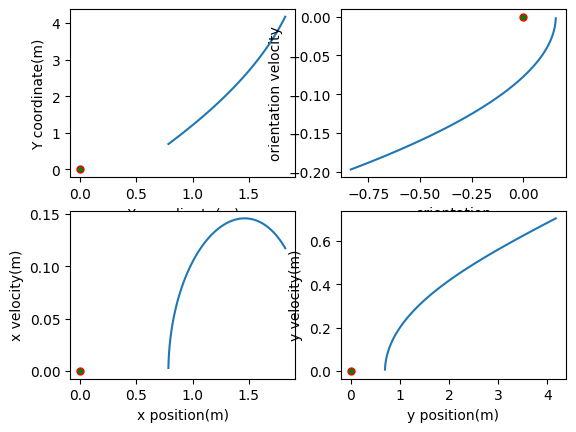

[2] loss: 9.645


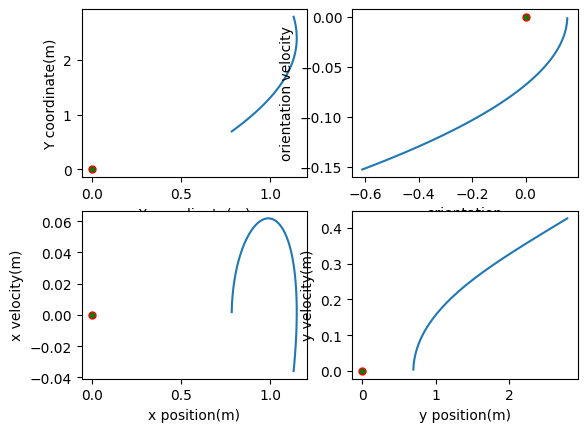

[3] loss: 4.757


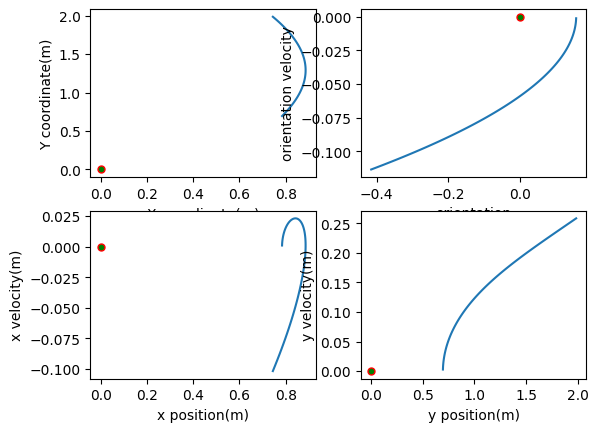

[4] loss: 2.557


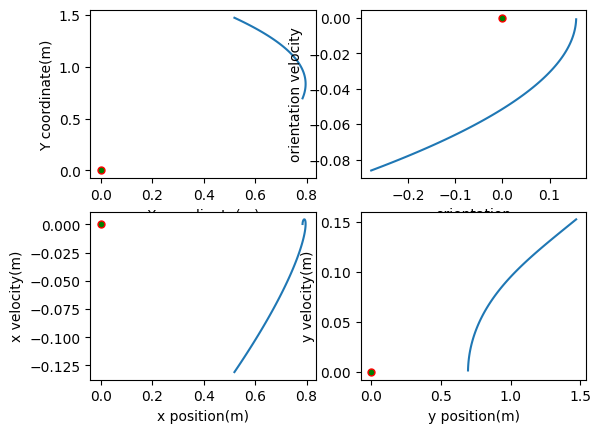

[5] loss: 1.441


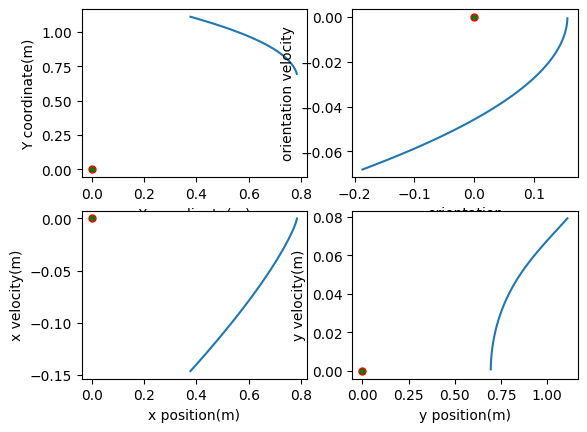

[6] loss: 0.834


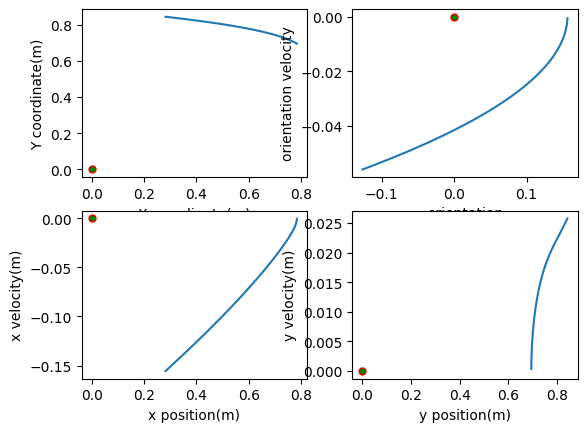

[7] loss: 0.496


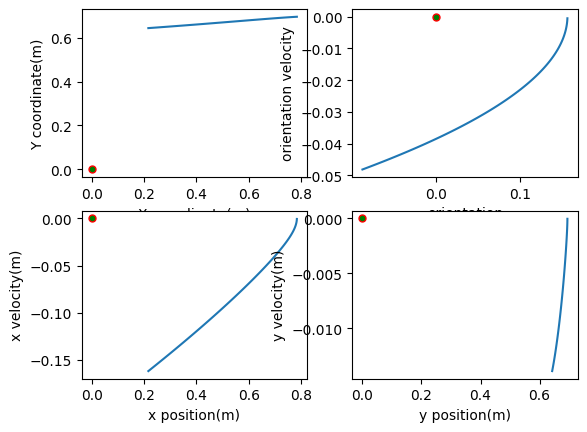

[8] loss: 0.307


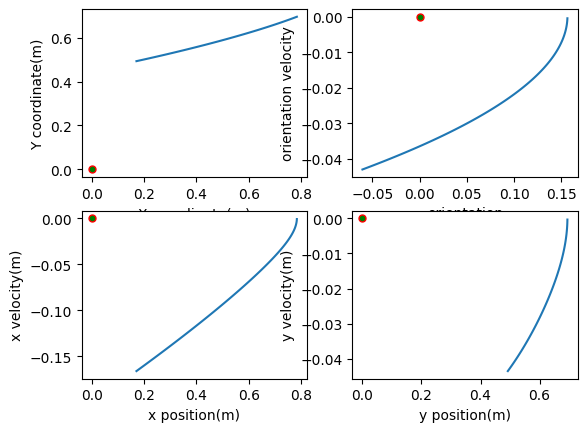

[9] loss: 0.199


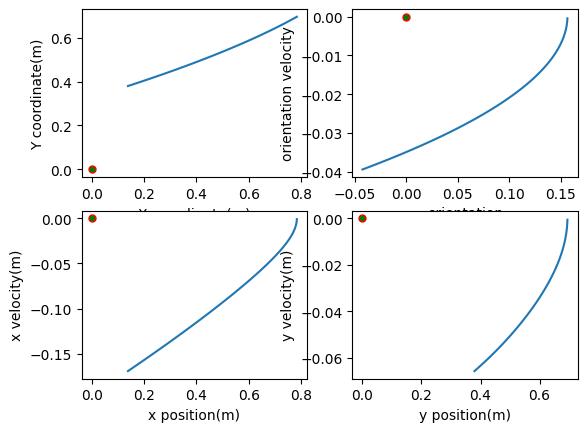

[10] loss: 0.139


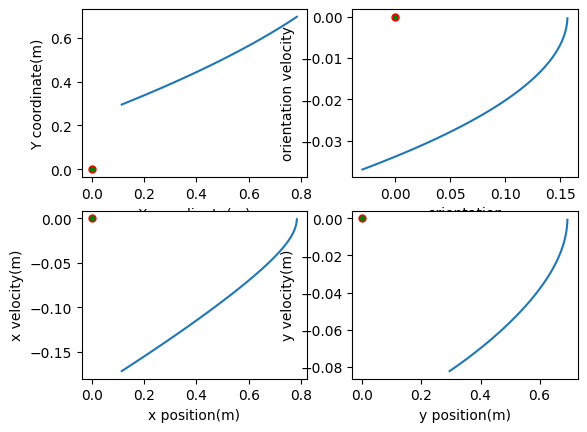

[11] loss: 0.105


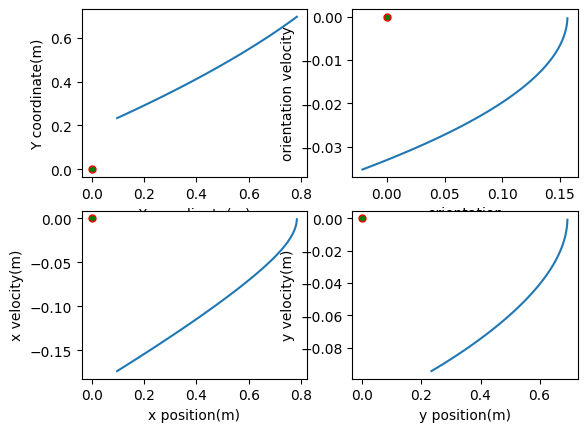

[12] loss: 0.085


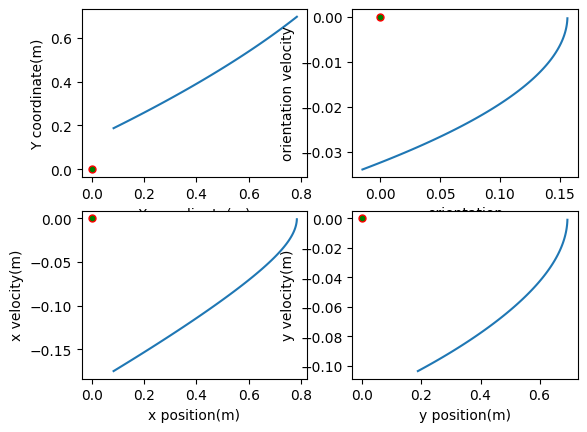

[13] loss: 0.072


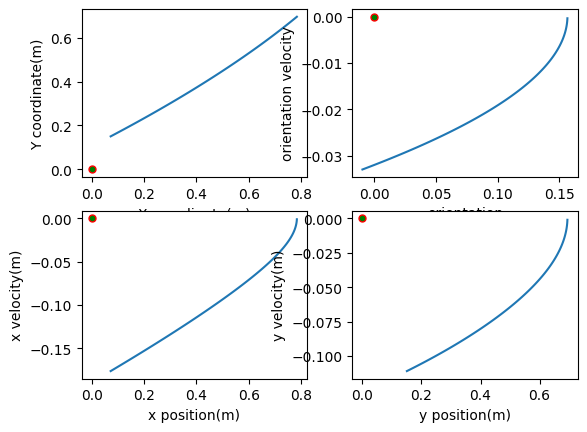

[14] loss: 0.064


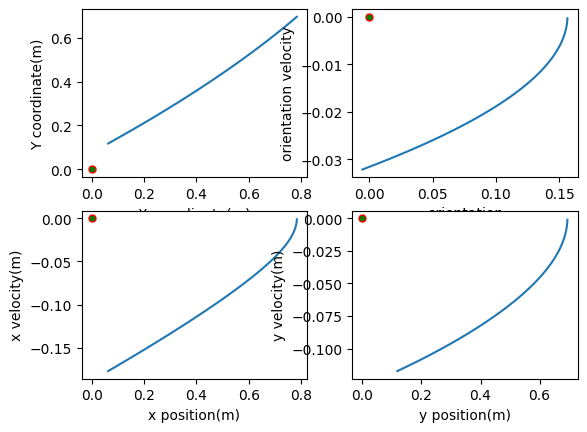

[15] loss: 0.059


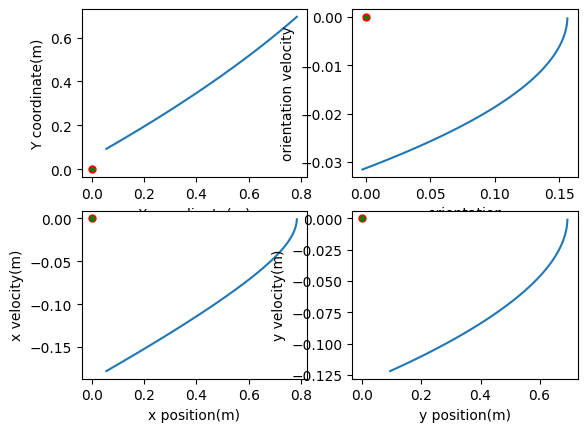

[16] loss: 0.057


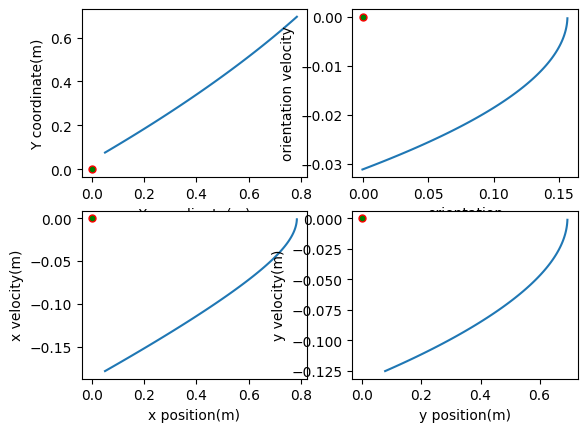

[17] loss: 0.056


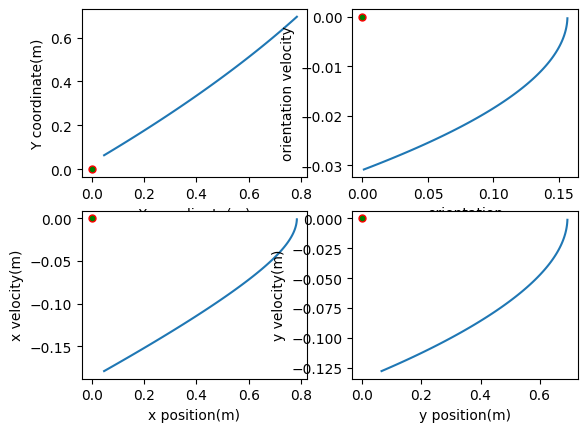

[18] loss: 0.055


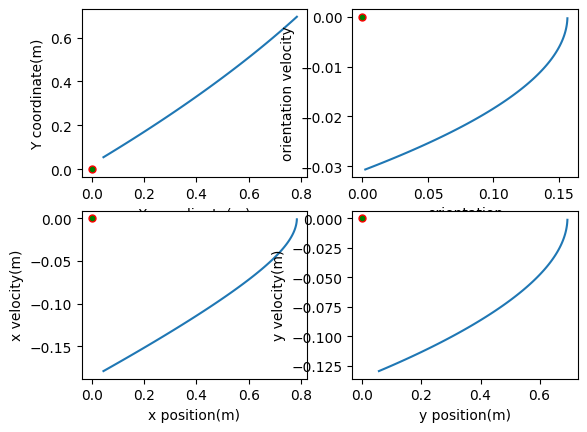

[19] loss: 0.054


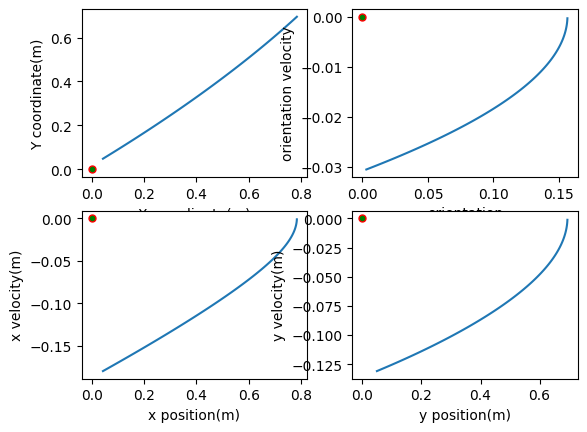

[20] loss: 0.054


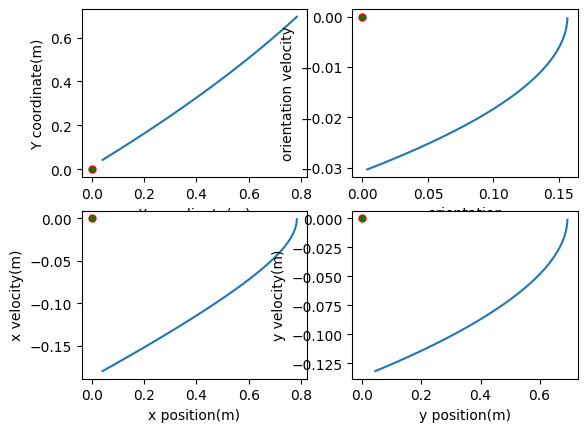

[21] loss: 0.054


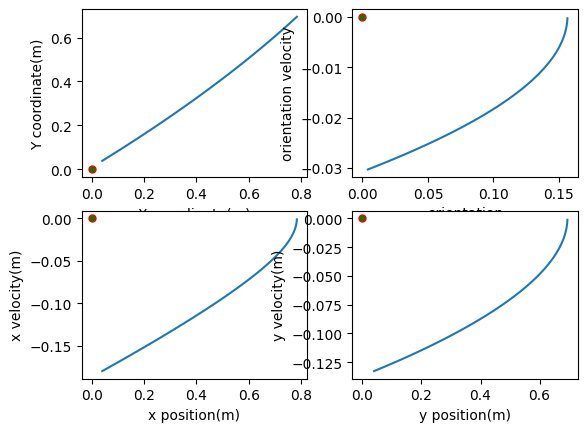

[22] loss: 0.054


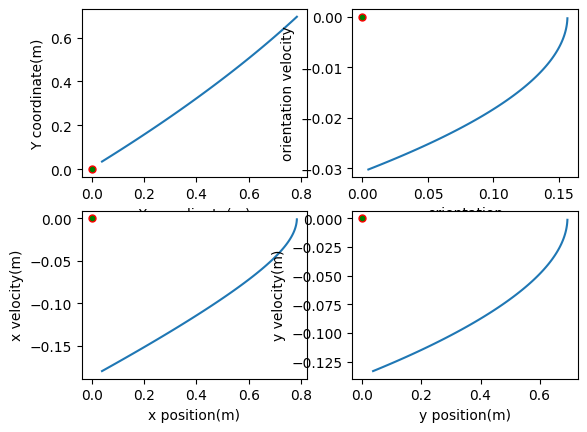

[23] loss: 0.054


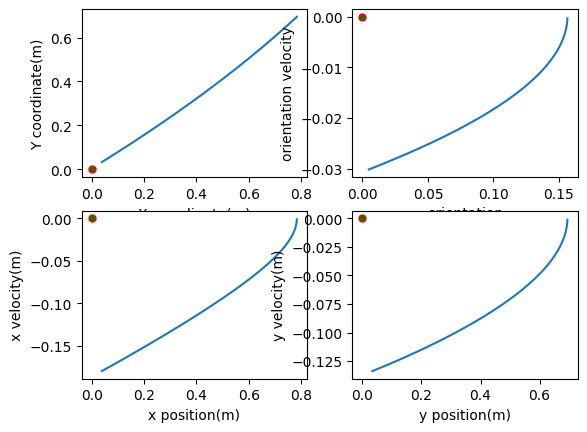

[24] loss: 0.054


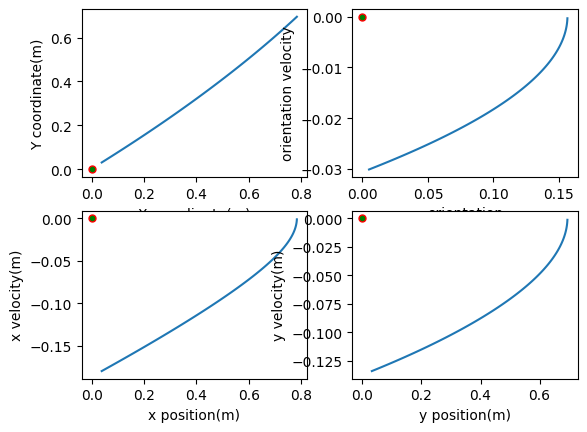

[25] loss: 0.054


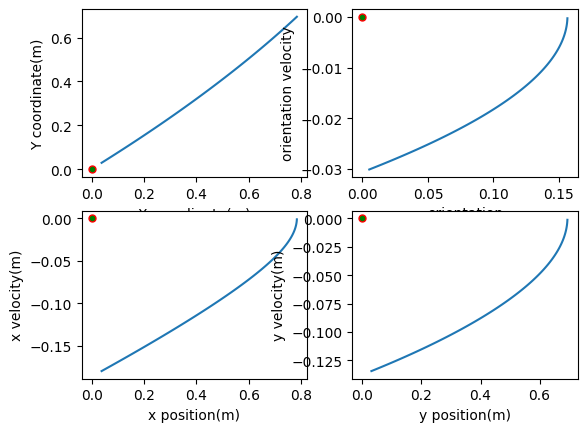

[26] loss: 0.054


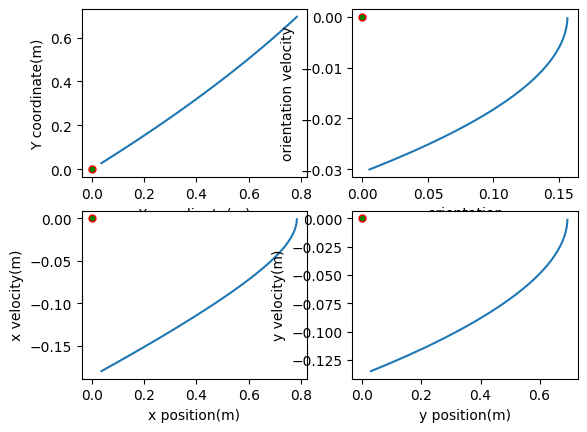

[27] loss: 0.054


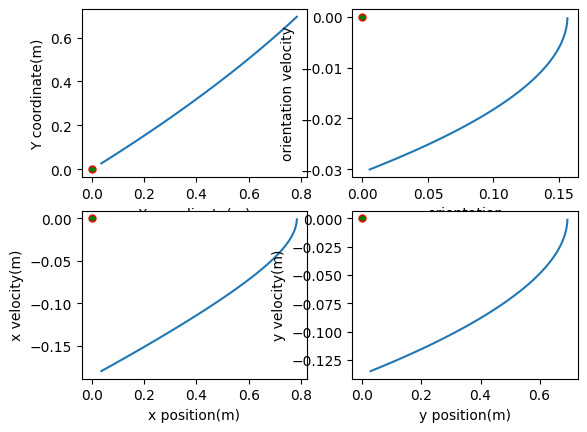

[28] loss: 0.054


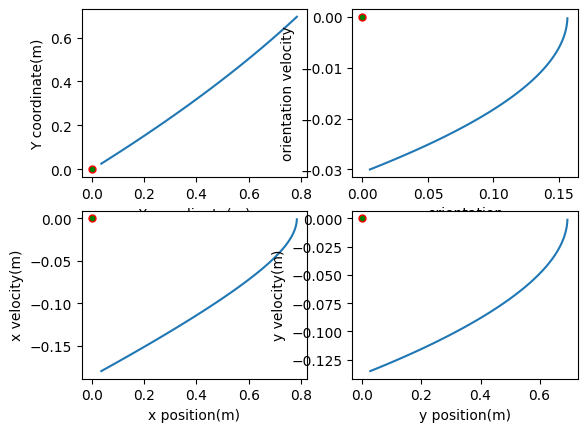

[29] loss: 0.054


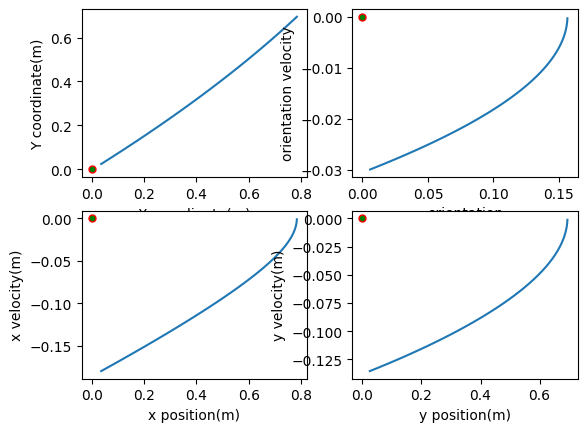

[30] loss: 0.054


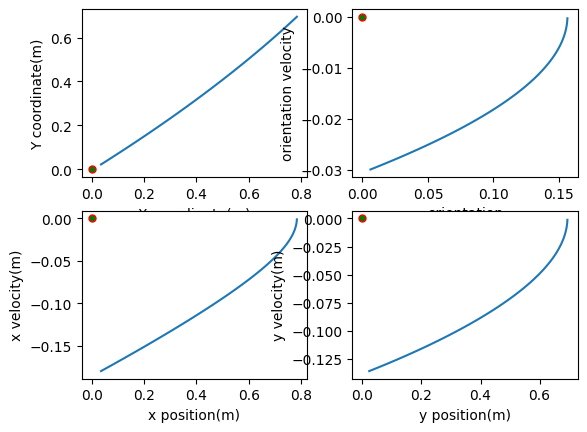

[31] loss: 0.053


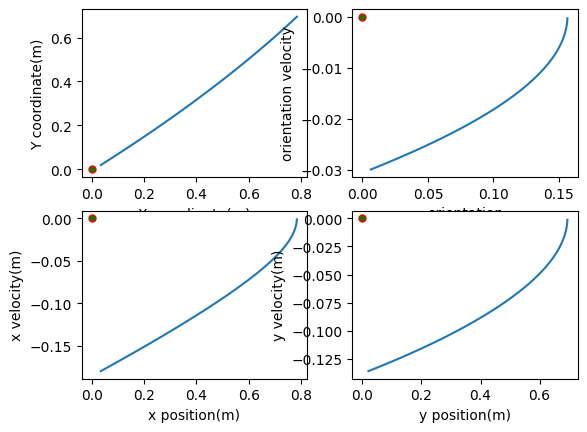

[32] loss: 0.053


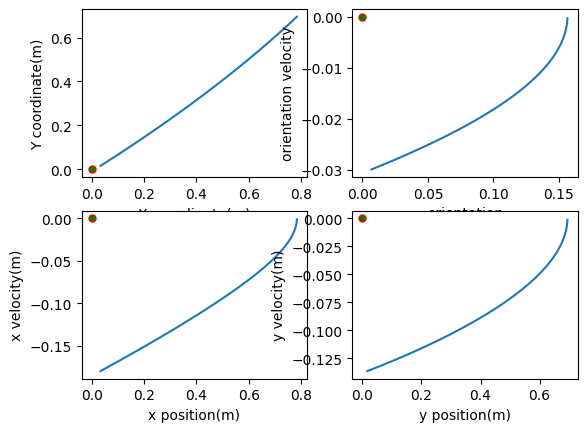

[33] loss: 0.053


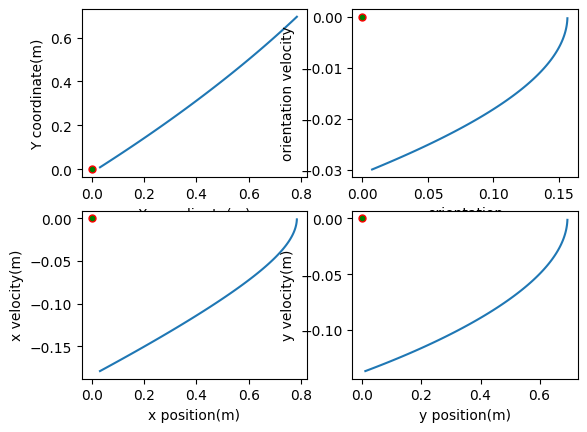

[34] loss: 0.048


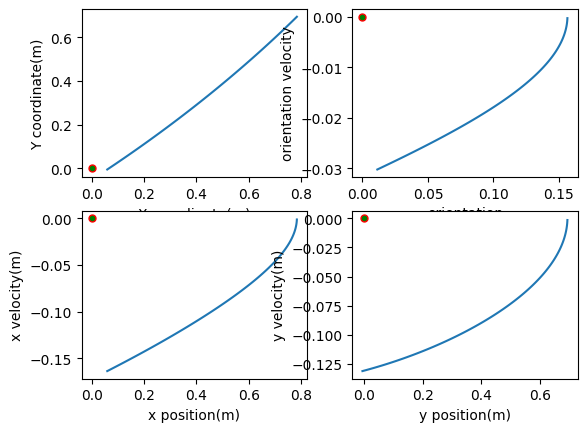

[35] loss: 0.046


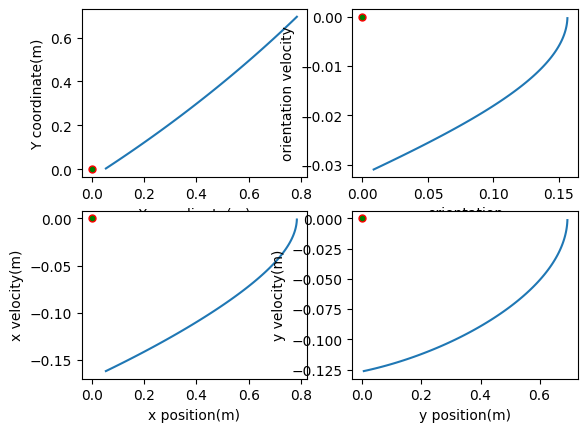

[36] loss: 0.038


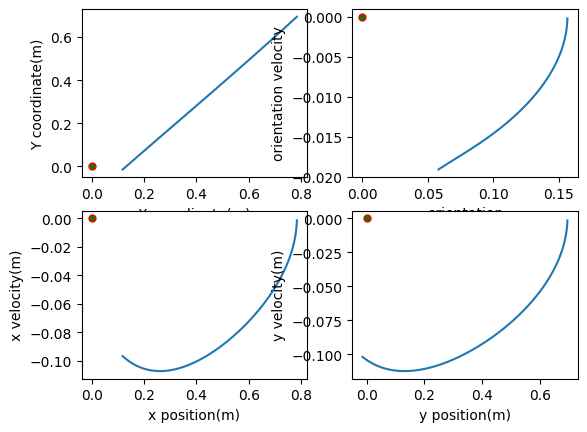

[37] loss: 0.027


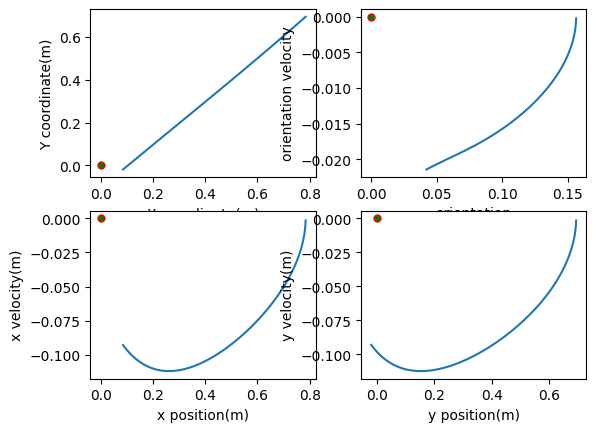

[38] loss: 0.013


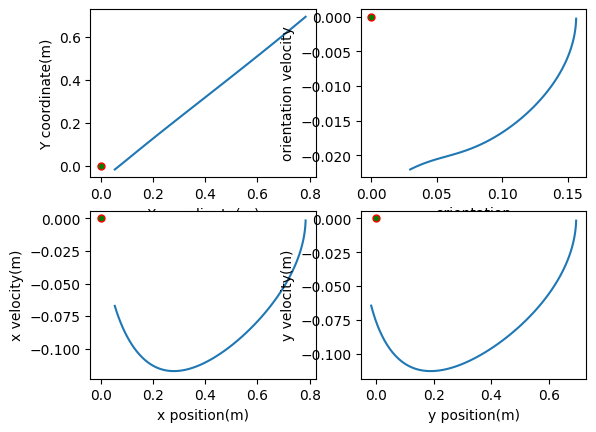

[39] loss: 0.007


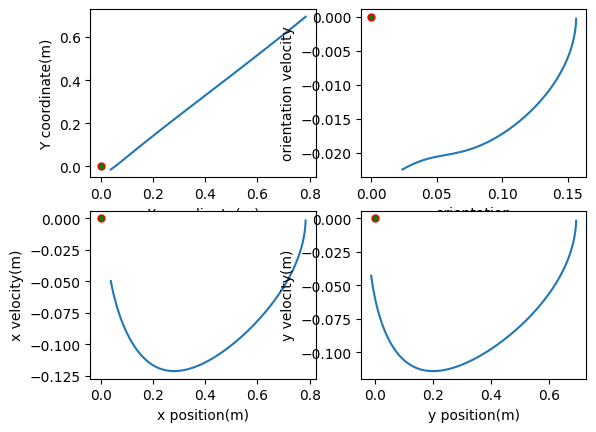

[40] loss: 0.004


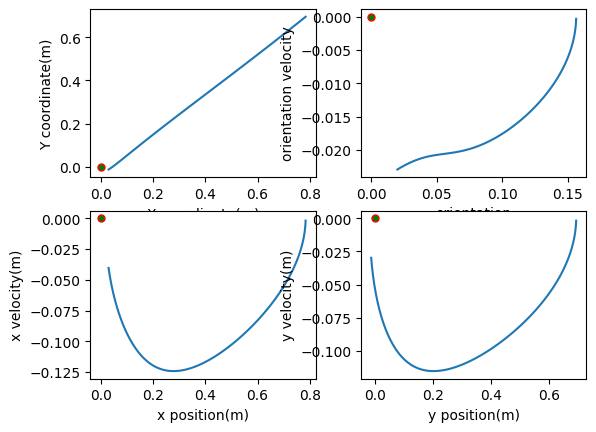

[41] loss: 0.003


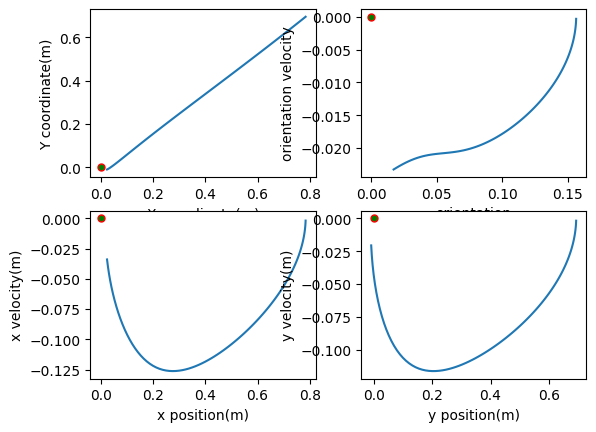

[42] loss: 0.002


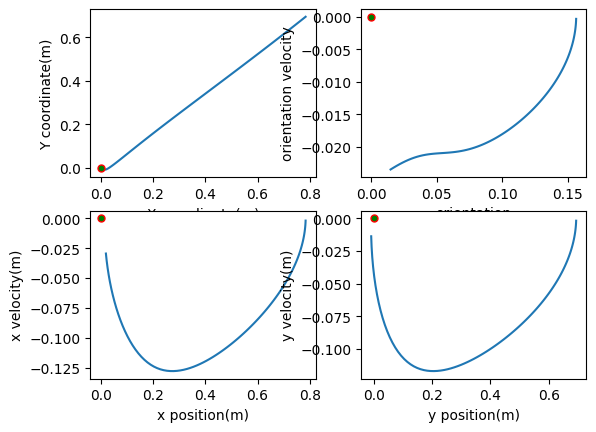

[43] loss: 0.002


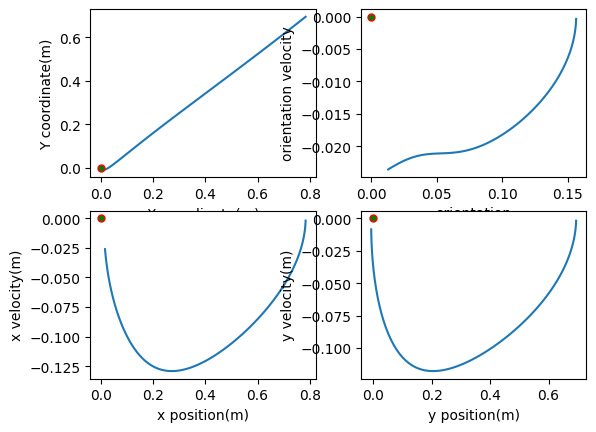

[44] loss: 0.001


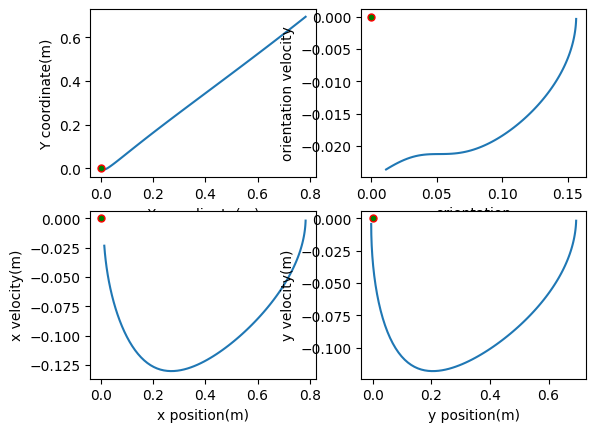

[45] loss: 0.001


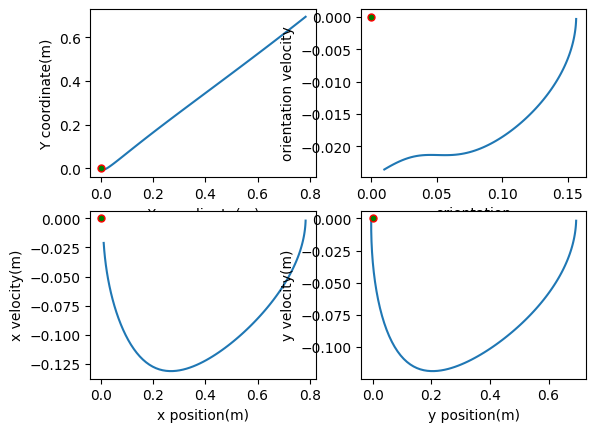

In [ ]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(100)  # solve the optimization problem
